# Pivot Tables

## Motivating Pivot Tables

In [8]:
import numpy as np
import pandas as pd
import seaborn as sns
titanic = sns.load_dataset('titanic')

In [9]:
titanic.head()

,survived,pclass,sex,age,sibsp,parch,fare,embarked,class,who,adult_male,deck,embark_town,alive,alone
0,0,3,male,22.0,1,0,7.2500,S,Third,man,True,NaN,Southampton,no,False
1,1,1,female,38.0,1,0,71.2833,C,First,woman,False,C,Cherbourg,yes,False
2,1,3,female,26.0,0,0,7.9250,S,Third,woman,False,NaN,Southampton,yes,True
3,1,1,female,35.0,1,0,53.1000,S,First,woman,False,C,Southampton,yes,False
4,0,3,male,35.0,0,0,8.0500,S,Third,man,True,NaN,Southampton,no,True


## Pivot Tables by Hand

In [10]:
# Survival rate by gender
titanic.groupby('sex')[['survived']].mean()

,survived
sex,
female,0.742038
male,0.188908


In [19]:
# Survival rate by class and sex
titanic.groupby(['sex', 'class'])[['survived']].aggregate('mean').unstack()

survived                    
class      First    Second     Third
sex                                 
female  0.968085  0.921053  0.500000
male    0.368852  0.157407  0.135447

This gives us a better idea of how both gender and class affected survival, but the code is starting to look a bit garbled. While each step of this pipeline makes sense in light of the tools we've previously discussed, the long string of code is not particularly easy to read or use. This two-dimensional `GroupBy` is common enough that Pandas includes a convenience routine, `pivot_table`, which succinctly handles this type of multi-dimensional aggregation.

## Pivot Table Syntax

Here is the equivalent to the preceding operation using the `pivot_table` method of `Dataframe`s:

In [22]:
titanic.pivot_table('survived', index='sex', columns='class')

class,First,Second,Third
sex,,,
female,0.968085,0.921053,0.500000
male,0.368852,0.157407,0.135447


## Multi-level pivot tables

Just as in the `GroupBy`, the grouping in pivot tbales can be specified with multiple levels, and via a number of options. For example, we might be interested in looking at age as a third dimension. we'll bin the age using the `pd.cut` function

In [23]:
age = pd.cut(titanic['age'], [0, 18, 80])
titanic.pivot_table('survived', ['sex', age], 'class')

class               First    Second     Third
sex    age                                   
female (0, 18]   0.909091  1.000000  0.511628
       (18, 80]  0.972973  0.900000  0.423729
male   (0, 18]   0.800000  0.600000  0.215686
       (18, 80]  0.375000  0.071429  0.133663

In [24]:
fare = pd.qcut(titanic['fare'], 2)
titanic.pivot_table('survived', ['sex', age], [fare, 'class'])

fare            (-0.001, 14.454]                     (14.454, 512.329]  \
class                      First    Second     Third             First   
sex    age                                                               
female (0, 18]               NaN  1.000000  0.714286          0.909091   
       (18, 80]              NaN  0.880000  0.444444          0.972973   
male   (0, 18]               NaN  0.000000  0.260870          0.800000   
       (18, 80]              0.0  0.098039  0.125000          0.391304   

fare                                 
class              Second     Third  
sex    age                           
female (0, 18]   1.000000  0.318182  
       (18, 80]  0.914286  0.391304  
male   (0, 18]   0.818182  0.178571  
       (18, 80]  0.030303  0.192308

## Additional pivot table options


In [25]:
titanic.pivot_table(index='sex', columns='class',
                   aggfunc={'survived':sum,'fare':'mean'})

fare                       survived             
class        First     Second      Third    First Second Third
sex                                                           
female  106.125798  21.970121  16.118810       91     70    72
male     67.226127  19.741782  12.661633       45     17    47

In [30]:
# Also calculate total
titanic.pivot_table('survived', index='sex', columns='class', margins=True)

class,First,Second,Third,All
sex,,,,
female,0.968085,0.921053,0.500000,0.742038
male,0.368852,0.157407,0.135447,0.188908
All,0.629630,0.472826,0.242363,0.383838


## Example: Birthrate Data

In [31]:
births = pd.read_csv('births.csv')

In [32]:
births.head()

,year,month,day,gender,births
0,1969,1,1.0,F,4046
1,1969,1,1.0,M,4440
2,1969,1,2.0,F,4454
3,1969,1,2.0,M,4548
4,1969,1,3.0,F,4548


In [35]:
births['decade'] = 10 * (births['year'] // 10)
births.pivot_table('births', index='decade', columns='gender', aggfunc='sum')

gender,F,M
decade,,
1960,1753634,1846572
1970,16263075,17121550
1980,18310351,19243452
1990,19479454,20420553
2000,18229309,19106428


Text(0,0.5,'total births per year')

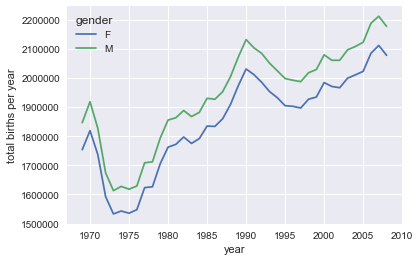

In [37]:
%matplotlib inline
import matplotlib.pyplot as plt
sns.set()
births.pivot_table('births', index='year', columns='gender', aggfunc='sum').plot()
plt.ylabel('total births per year')

## Further data exploration 

Though this doesn't necessarily relate to the pivot table, there are a few more interesting features we can pull out of this dataset using the Pandas tools covered up to this point. We must start by cleaning the data a bit, removing outliers caused by mistyped dates (e.g., June 31st) or missing values (e.g., June 99th). One easy way to remove these all at once is to cut outliers; we'll do this **via a robust sigma-clipping operation:**

In [41]:
quartiles = np.percentile(births['births'], [25, 50, 75])
mu = quartiles[1]
sig = 0.74 * (quartiles[2] - quartiles[0])

In [45]:
births = births.query('(births > @mu - 5 * @sig) & (births < @mu + 5 * @sig)')
births.head()

,year,month,day,gender,births,decade
0,1969,1,1.0,F,4046,1960
1,1969,1,1.0,M,4440,1960
2,1969,1,2.0,F,4454,1960
3,1969,1,2.0,M,4548,1960
4,1969,1,3.0,F,4548,1960


In [46]:
# set 'day' column to integer; it originally was a string
births['day'] = births['day'].astype(int)

In [50]:
# Create a datetime index from the year, month, day
births.index = pd.to_datetime(10000 * births.year +
                             100 * births.month +
                             births.day, format='%Y%m%d')

births['dayofweek'] = births.index.dayofweek
births.head()

,year,month,day,gender,births,decade,dayofweek
1969-01-01,1969,1,1,F,4046,1960,2
1969-01-01,1969,1,1,M,4440,1960,2
1969-01-02,1969,1,2,F,4454,1960,3
1969-01-02,1969,1,2,M,4548,1960,3
1969-01-03,1969,1,3,F,4548,1960,4


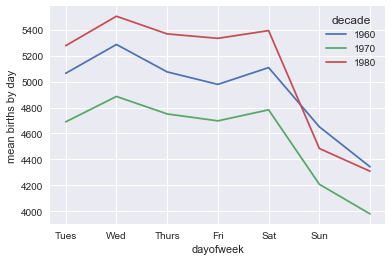

In [49]:
import matplotlib.pyplot as plt
import matplotlib as mpl

births.pivot_table('births', index='dayofweek',
                    columns='decade', aggfunc='mean').plot()
plt.gca().set_xticklabels(['Mon', 'Tues', 'Wed', 'Thurs', 'Fri', 'Sat', 'Sun'])
plt.ylabel('mean births by day');

In [51]:
births_by_date = births.pivot_table('births', 
                                    [births.index.month, births.index.day])
births_by_date.head()

births
1 1  4009.225
  2  4247.400
  3  4500.900
  4  4571.350
  5  4603.625

In [52]:
births_by_date.index = [pd.datetime(2012, month, day)
                        for (month, day) in births_by_date.index]
births_by_date.head()

,births
2012-01-01,4009.225
2012-01-02,4247.400
2012-01-03,4500.900
2012-01-04,4571.350
2012-01-05,4603.625


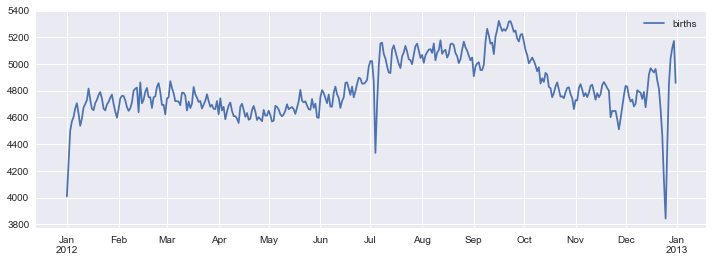

In [53]:
# Plot the results
fig, ax = plt.subplots(figsize=(12, 4))
births_by_date.plot(ax=ax);